In [1]:
!pip install ucimlrepo

In [37]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing data

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

X = X.drop(columns=['odor', 'stalk-root', 'ring-type', 'spore-print-color', 'population', 'habitat'])

# Split into train and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X train:', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train: (6499, 16)
y train (6499, 1)
X test (1625, 16)
y test (1625, 1)


# One-hot encode the features

In [5]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)
y_train_encoded = y_train['poisonous'].apply(lambda p: 1 if p=='p' else 0).to_numpy()
X_train_encoded.shape, y_train_encoded.shape

((6499, 76), (6499,))

# Train the model

In [6]:
def build_model(
    hidden_layer_sizes=[],
    dropout_rates=[],
    activation='relu',
    learning_rate=0.01,
    metric='accuracy'
):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    # Set input shape in advance
    model.add(tf.keras.Input(shape=(76,), name='Input'))

    for i, (hidden_layer_size, dropout_rate) in enumerate(zip(hidden_layer_sizes, dropout_rates)):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                      activation=activation,
                                      name=f'Hidden_{i}', use_bias=True))
      model.add(tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i}'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', metrics=[metric],optimizer=optimizer)

    return model


In [13]:
hidden_layer_sizes = [256, 256, 128, 128, 128, 64, 32]
dropout_rates = [0.5, 0.3, 0.2, 0.1, 0.1, 0]
model = build_model(
    hidden_layer_sizes=hidden_layer_sizes,
    dropout_rates=dropout_rates,
    activation='relu',
    learning_rate=0.01,
    metric='accuracy',
)

history = model.fit(
    x=X_train_encoded,
    y=y_train_encoded,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    # verbose=0
)



Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8143 - loss: 0.3531 - val_accuracy: 0.9692 - val_loss: 0.0603
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9805 - loss: 0.0609 - val_accuracy: 0.9892 - val_loss: 0.0250
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9852 - loss: 0.0461 - val_accuracy: 0.9862 - val_loss: 0.0482
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9887 - loss: 0.0382 - val_accuracy: 0.9908 - val_loss: 0.0292
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9799 - loss: 0.0801 - val_accuracy: 0.9877 - val_loss: 0.0337
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9656 - loss: 0.1124 - val_accuracy: 0.9738 - val_loss: 0.0605
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9725 - loss: 0.0874 - val_accuracy: 0.9877 - val_loss: 0.0555
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9780 - loss: 0.0564 - val_accuracy: 0.9831 - val_

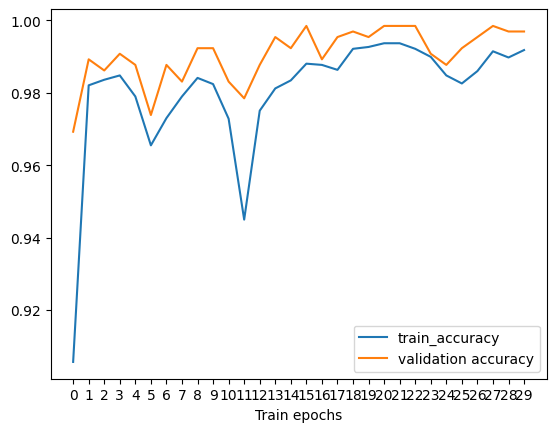

Training accuracy: 0.9918
Validation accuracy: 0.9969


In [14]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(30))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

print('Training accuracy: %1.4f' %train_accuracy[-1])
print('Validation accuracy: %1.4f' %val_accuracy[-1])

In [35]:
# Make predictions on the test set
X_test_encoded = encoder.transform(X_test)
y_test_encoded = y_test['poisonous'].apply(lambda p: 1 if p=='p' else 0).to_numpy()

y_pred = model.predict(X_test_encoded)
y_pred_labels = (y_pred > 0.25).astype(int)
y_pred_labels


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

FFNN:
Accuracy: 0.9975
Precision: 0.9949
Recall: 1.0000
F1 Score: 0.9974


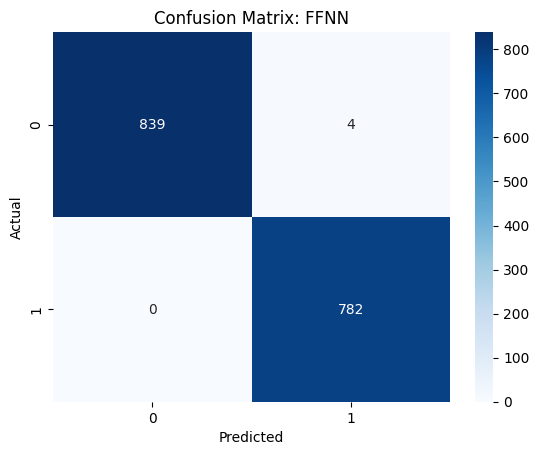

In [36]:
# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_labels)
precision = precision_score(y_test_encoded, y_pred_labels)
recall = recall_score(y_test_encoded, y_pred_labels)
f1 = f1_score(y_test_encoded, y_pred_labels)

print(f"FFNN:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: FFNN")
plt.show()

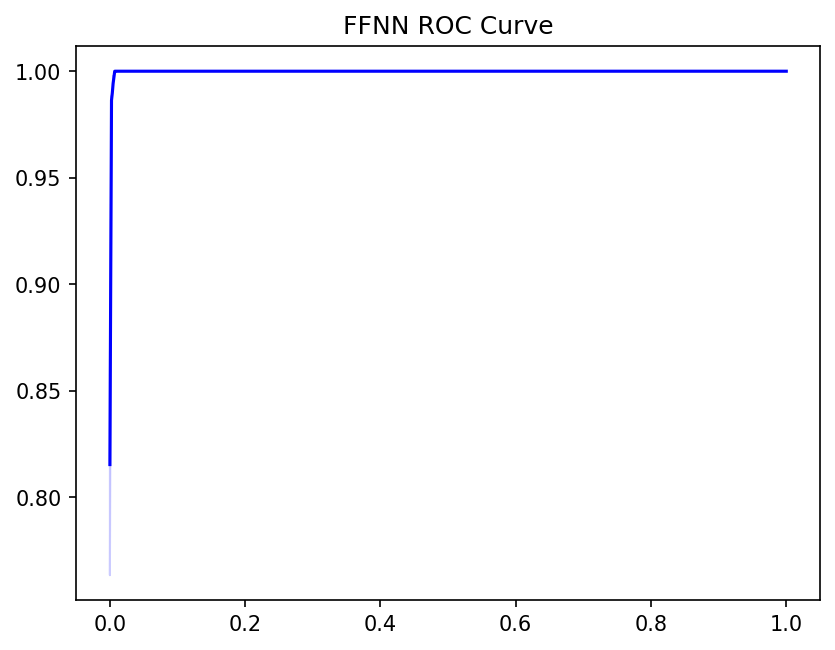

In [41]:
fpr, tpr, _ = metrics.roc_curve(y_test_encoded, y_pred)
auc = metrics.roc_auc_score(y_test_encoded, y_pred)

fig, ax = plt.subplots(dpi=150)
sns.lineplot(x=fpr, y=tpr, color='blue', ax=ax)
ax.set_title('FFNN ROC Curve')

plt.show()